<a href="https://colab.research.google.com/github/shrprabh/BraTS-PolypSegmentation/blob/feat%2Ftrainingwith1000samples/polysegmentationofbradtsdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install nibabel for handling NIfTI files
!pip install nibabel

# Import libraries
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose,
                                     BatchNormalization, Activation, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.3 MB/s eta 0:00:00


In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shrprabh","key":"323ee59f3e2f0c11df48be77bdb30712"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d awsaf49/brats2020-training-data


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats2020-training-data
License(s): CC0-1.0
100% 6.74G/6.76G [00:44<00:00, 209MB/s]
100% 6.76G/6.76G [00:44<00:00, 164MB/s]


In [5]:
!kaggle datasets download -d awsaf49/brats2020-training-data
!unzip -qq brats2020-training-data.zip -d brats2020


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats2020-training-data
License(s): CC0-1.0
brats2020-training-data.zip: Skipping, found more recently modified local copy (use --force to force download)


#Step 3: Data Preprocessing
#Load the images and masks, extract slices, and prepare them for training.#

In [8]:
import os
import h5py
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose,
                                     BatchNormalization, Activation, Dropout)

# Define your data directory
data_dir = 'brats2020/BraTS2020_training_data/content/data/'

# Initialize lists to store image and mask slices
image_slices = []
mask_slices = []

# Get the list of .h5 files and limit it to the first 200 files
file_list = [f for f in os.listdir(data_dir) if f.endswith('.h5')][:200]

# Loop over each .h5 file in the directory (only first 200)
for file_name in file_list:
    file_path = os.path.join(data_dir, file_name)

    # Open the .h5 file and load the data
    with h5py.File(file_path, 'r') as f:
        # Assuming 'image' and 'mask' are keys for image and mask data in the .h5 files.
        img_slice = np.array(f['image'])
        mask_slice = np.array(f['mask'])

        # Normalize image slice safely (add epsilon to avoid division by zero)
        epsilon = 1e-8
        img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + epsilon)

        # Resize image and mask to 256x256 for DUCKNet input
        img_resized = cv2.resize(img_slice, (256, 256))
        mask_resized = cv2.resize(mask_slice, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Expand dimensions to add channel axis (for CNN input)
        img_resized = np.expand_dims(img_resized[:, :, 0], axis=-1)   # Shape will be (256, 256, 1)
        mask_resized = np.expand_dims(mask_resized[:, :, 0], axis=-1) # Shape will be (256, 256, 1)

        # Append to lists
        image_slices.append(img_resized)
        mask_slices.append(mask_resized)

# Convert lists to NumPy arrays
X = np.array(image_slices)   # Shape will be (num_samples, 256, 256, 1)
y = np.array(mask_slices)    # Shape will be (num_samples, 256, 256, 1)

# Check for invalid data before training
print(np.isnan(X).sum(), np.isinf(X).sum())   # Should both be zero
print(np.isnan(y).sum(), np.isinf(y).sum())   # Should both be zero

# Split data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data loading complete.")

# Data augmentation parameters for training generator
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=90)

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

batch_size = 8

# Training generator function
def train_generator(X_train_data, y_train_data, batch_size):
    seed_value = 42
    image_generator = image_datagen.flow(X_train_data, batch_size=batch_size, seed=seed_value)
    mask_generator = mask_datagen.flow(y_train_data, batch_size=batch_size, seed=seed_value)
    return zip(image_generator, mask_generator)

train_gen = train_generator(X_train, y_train, batch_size)
steps_per_epoch = len(X_train) // batch_size

# Define DUCKNet architecture
def DUCKNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    # Block 1
    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2
    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3
    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4 (Bottom)
    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    drop4 = Dropout(0.5)(conv4)

    # Decoder
    up5 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(drop4)
    up5 = concatenate([up5, conv3], axis=-1)
    conv5 = Conv2D(256, 3, padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(256, 3, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    up6 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=-1)
    conv6 = Conv2D(128, 3, padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(128, 3, padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=-1)
    conv7 = Conv2D(64, 3, padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(64, 3, padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    conv8 = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=conv8)
    return model

# Build and compile the model
model = DUCKNet(input_size=(256, 256, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=(X_val, y_val))


0 0
0 0
Data loading complete.
Epoch 1/10
20/20 [==============================] - 86s 4s/step - loss: 0.3791 - accuracy: 0.9399 - val_loss: 0.0161 - val_accuracy: 0.9993
Epoch 2/10
20/20 [==============================] - 81s 4s/step - loss: 0.2354 - accuracy: 0.9965 - val_loss: 0.0143 - val_accuracy: 0.9974
Epoch 3/10
20/20 [==============================] - 81s 4s/step - loss: 0.1630 - accuracy: 0.9961 - val_loss: 0.0229 - val_accuracy: 0.9993
Epoch 4/10
20/20 [==============================] - 81s 4s/step - loss: 0.0759 - accuracy: 0.9959 - val_loss: 0.0336 - val_accuracy: 0.9975
Epoch 5/10
20/20 [==============================] - 81s 4s/step - loss: 0.0475 - accuracy: 0.9961 - val_loss: 0.0600 - val_accuracy: 0.9993
Epoch 6/10
20/20 [==============================] - 81s 4s/step - loss: 0.0390 - accuracy: 0.9963 - val_loss: 0.0587 - val_accuracy: 0.9993
Epoch 7/10
20/20 [==============================] - 81s 4s/step - loss: 0.0305 - accuracy: 0.9964 - val_loss: 0.0408 - val_accura

In [12]:
import os
import h5py
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose,
                                     BatchNormalization, Activation, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define your data directory
data_dir = 'brats2020/BraTS2020_training_data/content/data/'

# Initialize lists to store image and mask slices
image_slices = []
mask_slices = []

# Get the list of .h5 files and limit it to the first 1000 files
file_list = [f for f in os.listdir(data_dir) if f.endswith('.h5')][:1000]

# Loop over each .h5 file in the directory (only first 1000)
for file_name in file_list:
    file_path = os.path.join(data_dir, file_name)

    # Open the .h5 file and load the data
    with h5py.File(file_path, 'r') as f:
        # Assuming 'image' and 'mask' are keys for image and mask data in the .h5 files.
        img_slice = np.array(f['image'])
        mask_slice = np.array(f['mask'])

        # Skip files where the mask is completely black
        if np.max(mask_slice) == 0:
            continue  # Skip this slice as it contains no segmentation region

        # Normalize image slice safely (add epsilon to avoid division by zero)
        epsilon = 1e-8
        img_slice = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min() + epsilon)

        # Resize image and mask to 256x256 for DUCKNet input
        img_resized = cv2.resize(img_slice, (256, 256), interpolation=cv2.INTER_LINEAR)
        mask_resized = cv2.resize(mask_slice, (256, 256), interpolation=cv2.INTER_NEAREST)

        # Threshold the mask to ensure binary values (0 or 1)
        mask_resized = (mask_resized > 0.5).astype(np.float32)

        # Ensure the images are in the correct shape and data type
        if img_resized.ndim == 2:
            img_resized = np.expand_dims(img_resized, axis=-1)
        else:
            img_resized = img_resized[..., :1]  # Use the first channel

        if mask_resized.ndim == 2:
            mask_resized = np.expand_dims(mask_resized, axis=-1)
        else:
            mask_resized = mask_resized[..., :1]  # Use the first channel

        # Append to lists
        image_slices.append(img_resized)
        mask_slices.append(mask_resized)

# Convert lists to NumPy arrays
X = np.array(image_slices, dtype=np.float32)   # Shape will be (num_samples, 256, 256, 1)
y = np.array(mask_slices, dtype=np.float32)    # Shape will be (num_samples, 256, 256, 1)

# Normalize images to [0,1]
# Note: Masks are already binary (0 or 1) after thresholding
X = np.clip(X, 0, 1)  # Ensure X is in [0, 1]

# Check for invalid data before training
print('Total samples:', X.shape[0])
print('NaN in X:', np.isnan(X).sum(), 'Inf in X:', np.isinf(X).sum())   # Should both be zero
print('NaN in y:', np.isnan(y).sum(), 'Inf in y:', np.isinf(y).sum())   # Should both be zero

# Split data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation parameters for training generator
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=90,
                     fill_mode='nearest')

image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

batch_size = 8

# Training generator function
def train_generator(X_train_data, y_train_data, batch_size):
    seed_value = 42
    image_generator = image_datagen.flow(X_train_data, batch_size=batch_size, seed=seed_value)
    mask_generator = mask_datagen.flow(y_train_data, batch_size=batch_size, seed=seed_value)
    for img, mask in zip(image_generator, mask_generator):
        yield (img, mask)

train_gen = train_generator(X_train, y_train, batch_size)
steps_per_epoch = len(X_train) // batch_size

# Define DUCKNet architecture with dense blocks
def dense_block(x, filters, kernel_size=3, padding='same', activation='relu'):
    conv1 = Conv2D(filters, kernel_size, padding=padding)(x)
    bn1 = BatchNormalization()(conv1)
    act1 = Activation(activation)(bn1)
    concat1 = concatenate([x, act1], axis=-1)

    conv2 = Conv2D(filters, kernel_size, padding=padding)(concat1)
    bn2 = BatchNormalization()(conv2)
    act2 = Activation(activation)(bn2)
    concat2 = concatenate([x, act1, act2], axis=-1)

    conv3 = Conv2D(filters, kernel_size, padding=padding)(concat2)
    bn3 = BatchNormalization()(conv3)
    act3 = Activation(activation)(bn3)
    return act3

def DUCKNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    # Block 1
    db1 = dense_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(db1)

    # Block 2
    db2 = dense_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(db2)

    # Block 3
    db3 = dense_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(db3)

    # Block 4
    db4 = dense_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(db4)

    # Bottom
    db5 = dense_block(pool4, 1024)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(db5)
    merge6 = concatenate([up6, db4], axis=-1)
    db6 = dense_block(merge6, 512)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(db6)
    merge7 = concatenate([up7, db3], axis=-1)
    db7 = dense_block(merge7, 256)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(db7)
    merge8 = concatenate([up8, db2], axis=-1)
    db8 = dense_block(merge8, 128)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(db8)
    merge9 = concatenate([up9, db1], axis=-1)
    db9 = dense_block(merge9, 64)

    conv10 = Conv2D(1, 1, activation='sigmoid')(db9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

# Build and compile the model
model = DUCKNet(input_size=(256, 256, 1))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Set up callbacks
callbacks = [
    ModelCheckpoint('ducknet_brats.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
]

# Train the model
history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=2,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)


Total samples: 412
NaN in X: 0 Inf in X: 0
NaN in y: 0 Inf in y: 0
Epoch 1/2
41/41 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.9141 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 465s 11s/step - loss: 0.3746 - accuracy: 0.9141 - val_loss: 0.5955 - val_accuracy: 0.9808
Epoch 2/2
41/41 [==============================] - 445s 11s/step - loss: 0.1939 - accuracy: 0.9918 - val_loss: 0.5541 - val_accuracy: 0.9949


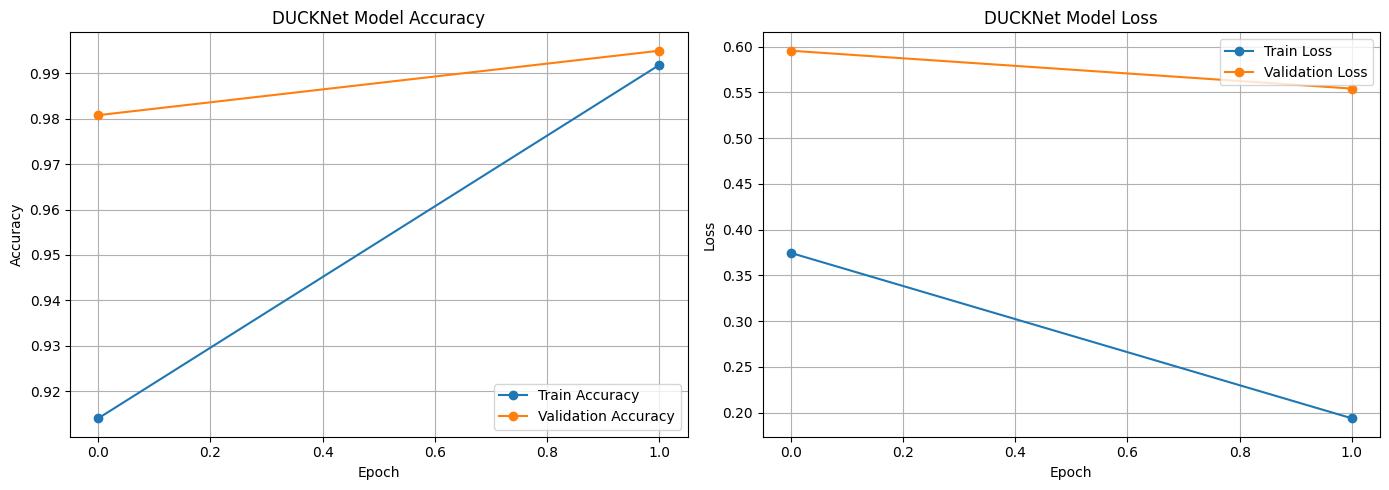

In [13]:
# Plot training & validation accuracy and loss values
import matplotlib.pyplot as plt

# Ensure inline plotting if using Jupyter Notebook
%matplotlib inline

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('DUCKNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('DUCKNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
import os

# Create directories for saving images and masks
output_dir = 'output_images'
os.makedirs(f"{output_dir}/train/images", exist_ok=True)
os.makedirs(f"{output_dir}/train/masks", exist_ok=True)
os.makedirs(f"{output_dir}/val/images", exist_ok=True)
os.makedirs(f"{output_dir}/val/masks", exist_ok=True)

# Save training images and masks
for i, (image, mask) in enumerate(zip(X_train, y_train)):
    cv2.imwrite(f"{output_dir}/train/images/image_{i}.png", (image * 255).astype(np.uint8))
    cv2.imwrite(f"{output_dir}/train/masks/mask_{i}.png", (mask * 255).astype(np.uint8))

# Save validation images and masks
for i, (image, mask) in enumerate(zip(X_val, y_val)):
    cv2.imwrite(f"{output_dir}/val/images/image_{i}.png", (image * 255).astype(np.uint8))
    cv2.imwrite(f"{output_dir}/val/masks/mask_{i}.png", (mask * 255).astype(np.uint8))
